# Excercise 2.1
## Train NN to evolve in time solution of Kuramoto-Sivashinsky equation and evaluate prediction on different initial conditions

Import usefull libraries

In [1]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
seed = np.random.seed(11467634)

Code to solve KS equation

In [2]:
N = 1024
x = (2*np.pi*np.arange(1,N+1)/N)
rng = default_rng(0)
u = rng.standard_normal(N).astype('float128')
v = fft(u)
nu = 0.05

# spatial grid and initial conditions
h = 0.01
k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float128')
L = k**2 - nu*k**4
exp1 = np.exp(h*L)
exp2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

tmax = 10
step_max = round(tmax/h)
step_plt = int(tmax/(1000*h))
g = -0.5j*k
# tt = np.zeros(step_max)
# uu = np.zeros((N,step_max))
uu = np.array([u])
tt = 0

for step in range(1, step_max):
    t = step*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = exp2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = exp2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = exp2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if step % step_plt == 0:
        u = np.real(ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
        # uu[:,step] = u
        # tt[step] = t '''

For training data discard first 150 points to remove initial trend 

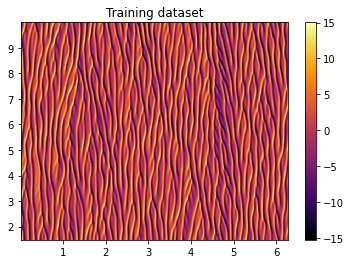

In [3]:
fig, ax = plt.subplots(1,1)
u0 = uu[0,:]
u = uu[149:,:]
t = tt[149:]
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, u, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Training dataset')
plt.show()

#print(np.shape(u))

Input of network are all timesteps except the last one

Output of network are timesteps from the second to the last one

In [4]:
u_input = u[0:-1,:]
u_output = u[1:,:]
#dt = t[1]-t[0]
#dx = x[2]-x[1]

min_u = np.min(u_input)
max_u = np.max(u_input)

u_input_n = (u_input-min_u)/(max_u-min_u)
u_output_n = (u_output-min_u)/(max_u-min_u)
#u_input_n = u_input
#u_output_n = u_output

print(np.shape(u_input_n))
print(np.shape(u_output_n))

(850, 1024)
(850, 1024)


Different NN architectures were tested

The third one is selected

In [5]:
#Input = tfk.Input(name = 'Input',shape=(1024,)) 
#layer_1 = tfkl.Dense(512, activation='relu', kernel_initializer='glorot_uniform')(Input) 
#layer_2 = tfkl.Dense(256, activation='relu', kernel_initializer='glorot_uniform')(layer_1) 
#layer_3 = tfkl.Dense(512, activation='relu', kernel_initializer='glorot_uniform')(layer_2)
#Output = tfkl.Dense(1024)(layer_3) 
#NN_1 = tfk.Model(inputs=Input, outputs=Output, name="NN_1")
#NN_1.summary() tfk.utils.plot_model(NN_1, "NN_1.png")

In [6]:
#Input = tfk.Input(name = 'Input',shape=(1024,))
#layer_1 = tfkl.Dense(512, activation='relu', kernel_initializer='glorot_uniform')(Input)
#layer_2 = tfkl.Dense(256, activation='relu', kernel_initializer='glorot_uniform')(layer_1)
#layer_3 = tfkl.Dense(128, activation='relu', kernel_initializer='glorot_uniform')(layer_2)
#layer_4 = tfkl.Dense(256, activation='relu', kernel_initializer='glorot_uniform')(layer_3)
#layer_5 = tfkl.Dense(512, activation='relu', kernel_initializer='glorot_uniform')(layer_4)
#Output = tfkl.Dense(1024)(layer_5)
#NN_1 = tfk.Model(inputs=Input, outputs=Output, name="NN_2")
#NN_1.summary()
#tfk.utils.plot_model(NN_1, "NN_2.png")

Selected network

2022-07-13 15:09:33.873353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:09:33.961209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:09:33.962436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:09:33.964208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "NN_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 3072)              3148800   
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              3146752   
Total params: 25,176,064
Trainable params: 25,176,064
Non-trainable params: 0
_________________________________________________________________


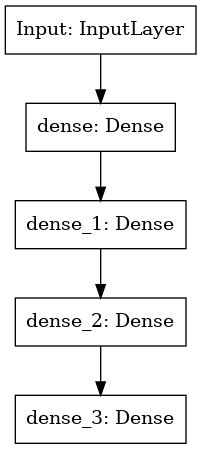

In [7]:
Input = tfk.Input(name = 'Input',shape=(1024,))
layer_1 = tfkl.Dense(3072, activation='relu', kernel_initializer='glorot_uniform')(Input)
layer_2 = tfkl.Dense(3072, activation='relu', kernel_initializer='glorot_uniform')((layer_1))
layer_3 = tfkl.Dense(3072, activation='relu', kernel_initializer='glorot_uniform')((layer_2))
Output = tfkl.Dense(1024)(layer_3)
NN_1 = tfk.Model(inputs=Input, outputs=Output, name="NN_3")
NN_1.summary()
tfk.utils.plot_model(NN_1, "NN_3.png")

Best settings for training

In [8]:
callbacks = [#tfk.callbacks.EarlyStopping(monitor = "val_loss",
             #              patience = 100,
             #              restore_best_weights = True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                   factor = 0.9,
                                   patience = 50,
                                   min_lr = 1e-6)]
            
metrics = [tf.keras.metrics.MeanSquaredError(name="MSE", dtype=None),
          tf.keras.metrics.RootMeanSquaredError(name="RMSE", dtype=None),
          tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None)]
optimizer = tfk.optimizers.Adam(name="Adam")
loss = tfk.losses.MeanSquaredError()
epochs = 3000
batch_size = 100

Training of NN

In [9]:
NN_1.compile(optimizer=optimizer,loss=loss,metrics = metrics)
history=NN_1.fit(x=u_input_n,y=u_output_n,batch_size = batch_size,
        epochs = epochs, callbacks = callbacks,
        validation_split = 0.2).history

2022-07-13 15:09:37.537139: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3000
7/7 [==============================] - 2s 56ms/step - loss: 0.3002 - MSE: 0.3002 - RMSE: 0.5479 - mae: 0.4337 - val_loss: 0.0549 - val_MSE: 0.0549 - val_RMSE: 0.2344 - val_mae: 0.1922
Epoch 2/3000
7/7 [==============================] - 0s 14ms/step - loss: 0.0501 - MSE: 0.0501 - RMSE: 0.2238 - mae: 0.1813 - val_loss: 0.0451 - val_MSE: 0.0451 - val_RMSE: 0.2124 - val_mae: 0.1738
Epoch 3/3000
7/7 [==============================] - 0s 13ms/step - loss: 0.0369 - MSE: 0.0369 - RMSE: 0.1922 - mae: 0.1576 - val_loss: 0.0433 - val_MSE: 0.0433 - val_RMSE: 0.2081 - val_mae: 0.1716
Epoch 4/3000
7/7 [==============================] - 0s 10ms/step - loss: 0.0348 - MSE: 0.0348 - RMSE: 0.1867 - mae: 0.1534 - val_loss: 0.0417 - val_MSE: 0.0417 - val_RMSE: 0.2042 - val_mae: 0.1682
Epoch 5/3000
7/7 [==============================] - 0s 11ms/step - loss: 0.0338 - MSE: 0.0338 - RMSE: 0.1838 - mae: 0.1510 - val_loss: 0.0409 - val_MSE: 0.0409 - val_RMSE: 0.2023 - val_mae: 0.1665
Epoch 6/3000
7/

In [10]:
#NN_1.save('net_2.h5')

We plot loss evolution during the training phase together with the metrics evolution and the LR evolution

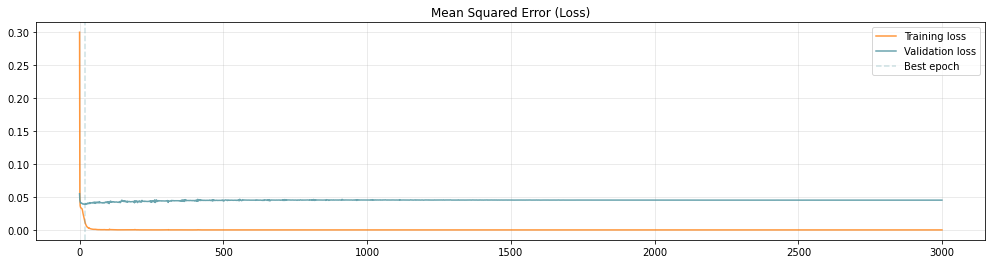

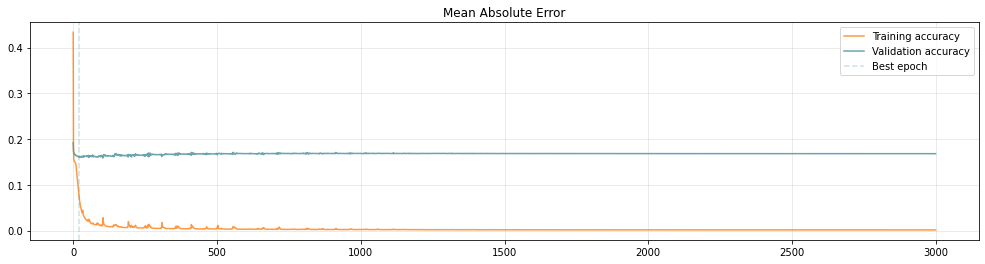

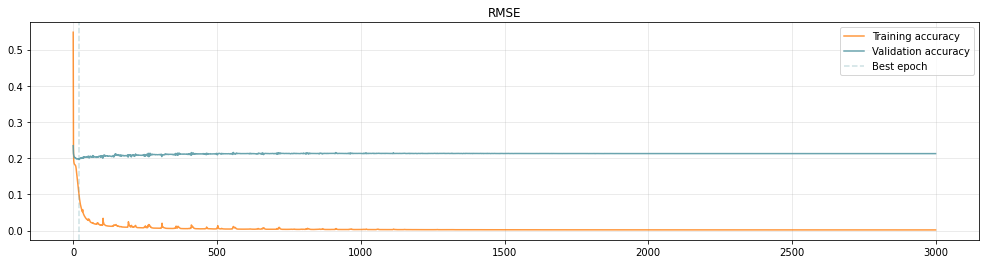

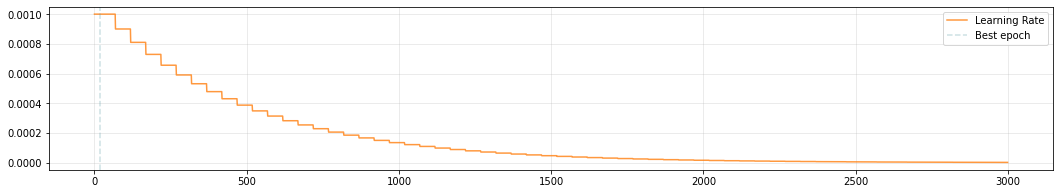

In [11]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['RMSE'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_RMSE'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('RMSE')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()


Network prediction on the training dataset

In [12]:
net_pred = np.zeros(np.shape(u))
net_pred[0,:] = u_input_n[0,:]
for i in range(np.shape(net_pred)[0]-1):
    i0 = net_pred[i,:]
    i0 = i0.reshape( (1,1024) )
    net_pred[i+1,:] = NN_1.predict(i0)
    
print(np.shape(net_pred))
net_pred = net_pred*(max_u-min_u)+min_u

(851, 1024)


Network prediction is plotted together with the error with respect to the training set

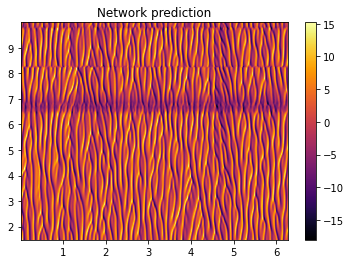

In [13]:
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, net_pred, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Network prediction')
plt.show()

As we can see the network is able to correctly replicate the dynamics of the system up to a certain time instant.

Then the NN prediction remains contant 

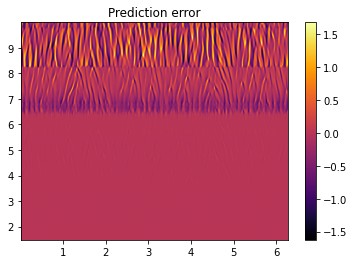

In [14]:
err_pred = (net_pred-u)/((np.max(u)-np.min(u))/2)
np.shape(err_pred)
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, err_pred, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Prediction error')
plt.show()

Now we build two other solutions of the KS equation but with different initial conditions:
* different random initialization
* Fourier initialization

In [15]:
N = 1024
seed = np.random.seed(2001)
x = (2*np.pi*np.arange(1,N+1)/N)
rng = default_rng(1)
u = rng.standard_normal(N).astype('float128')
v = fft(u)
nu = 0.05

# spatial grid and initial conditions
h = 0.01
k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float128')
L = k**2 - nu*k**4
exp1 = np.exp(h*L)
exp2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

tmax = 10
step_max = round(tmax/h)
step_plt = int(tmax/(1000*h))
g = -0.5j*k
# tt = np.zeros(step_max)
# uu = np.zeros((N,step_max))
uu = np.array([u])
tt = 0

for step in range(1, step_max):
    t = step*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = exp2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = exp2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = exp2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if step % step_plt == 0:
        u = np.real(ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
        # uu[:,step] = u
        # tt[step] = t '''
        
uu1 = uu
u1 = uu1[0,:]

In [16]:
N = 1024
seed = np.random.seed(2001)
x = (2*np.pi*np.arange(1,N+1)/N)
rng = default_rng(1)
u = -np.sin(x)+2*np.cos(2*x)+3*np.cos(3*x)-4*np.sin(4*x)
#u = rng.standard_normal(N).astype('float128')
v = fft(u)
nu = 0.05

# spatial grid and initial conditions
h = 0.01
k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float128')
L = k**2 - nu*k**4
exp1 = np.exp(h*L)
exp2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

tmax = 10
step_max = round(tmax/h)
step_plt = int(tmax/(1000*h))
g = -0.5j*k
# tt = np.zeros(step_max)
# uu = np.zeros((N,step_max))
uu = np.array([u])
tt = 0

for step in range(1, step_max):
    t = step*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = exp2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = exp2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = exp2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if step % step_plt == 0:
        u = np.real(ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
        # uu[:,step] = u
        # tt[step] = t '''
        
uu2 = uu
u2 = uu2[0,:]

Plot of different initial conditions

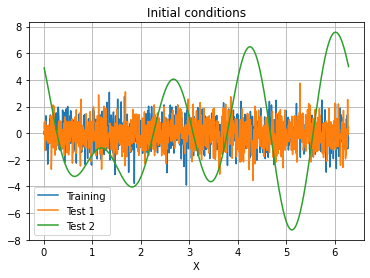

In [17]:
plt.figure()
plt.plot(x,u0,label='Training')
plt.plot(x,u1,label='Test 1')
plt.plot(x,u2,label='Test 2')
plt.grid()
plt.legend()
plt.xlabel('X')
plt.title('Initial conditions')
plt.show()

Comparison between two test datasets

In order to remove the initial transition for the second dataset only51 points are kept for the second dataset

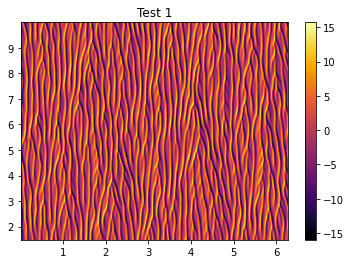

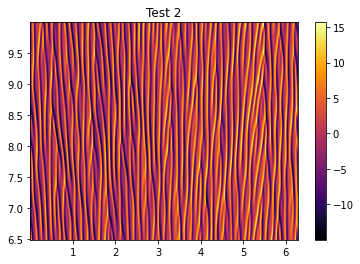

In [18]:
fig, ax = plt.subplots(1,1)
uu_1 = uu1[149:,:]
t1 = tt[149:]
X, T1 = np.meshgrid(x, t1)
im = ax.pcolormesh(X, T1, uu_1, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Test 1')
plt.show()

fig, ax = plt.subplots(1,1)
uu_2 = uu2[649:,:]
t2 = tt[649:]
X, T2 = np.meshgrid(x, t2)
im = ax.pcolormesh(X, T2, uu_2, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Test 2')
plt.show()


In [19]:
#NN_1 = tfk.models.load_model('../input/network-2/net_2.h5')

NN prediction on first test dataset

In [20]:
net_pred_1 = np.zeros(np.shape(uu_1))
net_pred_1[0,:] = uu_1[0,:]
net_pred_1 = (net_pred_1-min_u)/(max_u-min_u)
for i in range(np.shape(net_pred_1)[0]-1):
    i0 = net_pred_1[i,:]
    i0 = i0.reshape( (1,1024) )
    net_pred_1[i+1,:] = NN_1.predict(i0)

net_pred_1 = net_pred_1*(max_u-min_u)+min_u    
err_pred_1 = (net_pred_1-uu_1)/((np.max(uu_1)-np.min(uu_1))/2)

#print(np.shape(net_pred_1))

Plot of NN prediction and error

As we can see the network is not very good in generalizing if a different initial condition is assigned

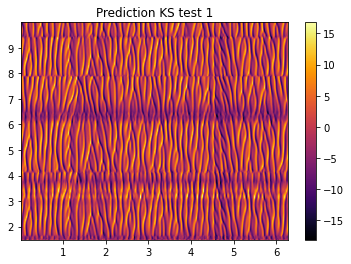

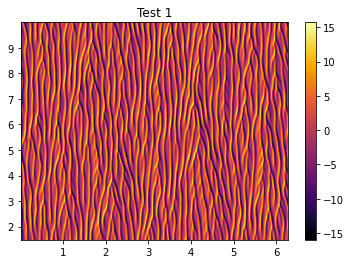

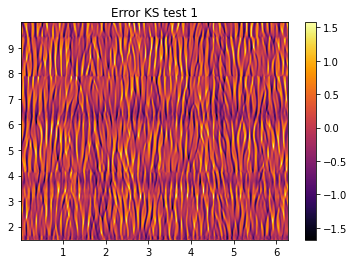

In [21]:
fig, ax = plt.subplots(1,1)
X, T1 = np.meshgrid(x, t1)
im = ax.pcolormesh(X, T1, net_pred_1, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Prediction KS test 1')
plt.show()

fig, ax = plt.subplots(1,1)
X, T1 = np.meshgrid(x, t1)
im = ax.pcolormesh(X, T1, uu_1, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Test 1')
plt.show()

fig, ax = plt.subplots(1,1)
X, T1 = np.meshgrid(x, t1)
im = ax.pcolormesh(X, T1, err_pred_1, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Error KS test 1')
plt.show()


The same is repeated for the second initial condition

In [22]:
net_pred_2 = np.zeros(np.shape(uu_2))
net_pred_2[0,:] = uu_2[0,:]
net_pred_2 = (net_pred_2-min_u)/(max_u-min_u)
for i in range(np.shape(net_pred_2)[0]-1):
    i0 = net_pred_2[i,:]
    i0 = i0.reshape( (1,1024) )
    net_pred_2[i+1,:] = NN_1.predict(i0)
    
print(np.shape(net_pred_2))
net_pred_2 = net_pred_2*(max_u-min_u)+min_u
err_pred_2 = (net_pred_2-uu_2)/((np.max(uu_2)-np.min(uu_2))/2)

(351, 1024)


Also in this case the network is not effective when a different initial condition is applied

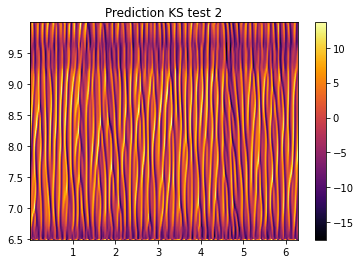

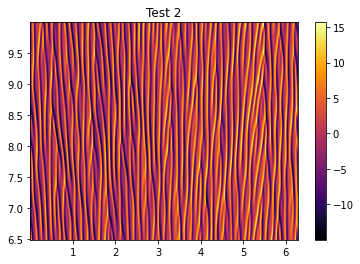

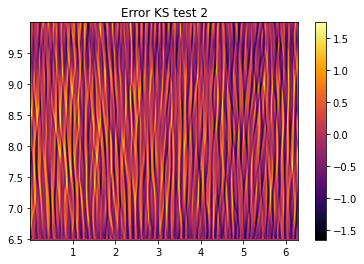

In [23]:
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t2)
im = ax.pcolormesh(X, T2, net_pred_2, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Prediction KS test 2')
plt.show()

fig, ax = plt.subplots(1,1)
X, T2 = np.meshgrid(x, t2)
im = ax.pcolormesh(X, T2, uu_2, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Test 2')
plt.show()

fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t2)
im = ax.pcolormesh(X, T2, err_pred_2, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.title('Error KS test 2')
plt.show()
